In [25]:
# Urllib library used to query a website
from urllib.request import urlopen
# BeautifulSoup webscraping module for python
from bs4 import BeautifulSoup
# CSV parser
import csv
# Regular expressions
import re
import nltk
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
import enchant
import wordcloud
us_d = enchant.Dict("en_US")
uk_d = enchant.Dict("en_GB")

In [26]:
# Process individual case given CELEX number
def scrapeText(url):
    print("Source: " + str(url))
    # Open the page
    judgement_page = urlopen(url)
    # Convert it to BeautifulSoup format 
    soup_judgement_page = BeautifulSoup(judgement_page, "html.parser")
    return soup_judgement_page

In [27]:
def preprocess(text):
    text = text.lower() # lowercase
    text_p = "".join([char for char in text if char not in string.punctuation]) # no punctuation
    text_nonum = re.sub(r'\d+', '', text_p) # no numbers
    words = word_tokenize(text_nonum) # split into tokens (words)
    stop_words = stopwords.words('english')
    stop_words.append('article')
    stop_words.append('eurlex')
    filtered_words = [word for word in words if word not in stop_words] # remove english stopwords
    tokens = []
    for item in filtered_words: # remove all 1 and 2 character words
        if (len(item) > 2):
            tokens.append(item)
    tokens_noduplicates = list(set(tokens)) # remove duplicates
    pos = pos_tag(tokens_noduplicates) # postag text
    dictionary_words = []
    for item in tokens_noduplicates: # remove all non-dictionary words
        if (uk_d.check(item) or us_d.check(item)):
            dictionary_words.append(item)
    return tokens, tokens_noduplicates, dictionary_words, pos

In [28]:
parsed_page = scrapeText("https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=celex:32017L1132")

Source: https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=celex:32017L1132


In [29]:
result = preprocess(parsed_page.text)

In [30]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
joined_words = " ".join(result[0])+" "
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = [], min_font_size = 10).generate(joined_words) 

19396

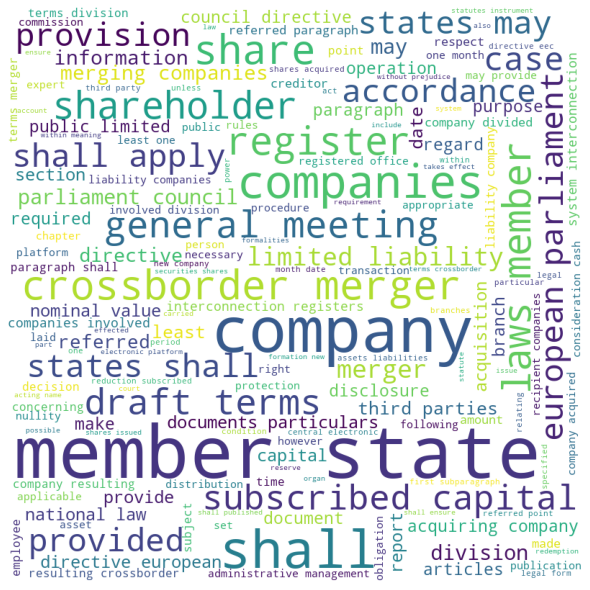

In [31]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)   
plt.show() 

In [32]:
# result[1]